## PETALO reconstruction

This notebook shows how to do image reconstruction and analyse the images to make comparison.
The input file contains a dataframe with the following columns: true_r1, true_phi1, true_z1, true_t1, reco_r1, reco_phi1, reco_z1, reco_t1, true_r2, true_phi2, true_z2, true_t2, reco_r2, reco_phi2, reco_z2, reco_t2   

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import antea.image.fom_functions as fomf
import mlem.mlem_reconstruct as myreco

In [2]:
## Configuration for plots ##
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 10, 7.5

ms = 7
lw = 2
ecolor='black'
capsize=3

## colors
tableau = [( 31, 119, 180), (174, 199, 232), (255, 127,  14), (255, 187, 120),
           ( 44, 160,  44), (152, 223, 138), (214,  39,  40), (255, 152, 150),
           (148, 103, 189), (197, 176, 213), (140,  86,  75), (196, 156, 148),
           (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
           (188, 189,  34), (219, 219, 141), ( 23, 190, 207), (158, 218, 229), 
           (218,  60,  78), (35,  180, 203)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau)):
    r, g, b = tableau[i]
    tableau[i] = (r / 255., g / 255., b / 255.)

blue   = tableau[0]
green  = tableau[4]
fucsia = tableau[6]
light_red   = tableau[20]
light_blue  = tableau[21]

Functions to read the data

In [3]:
def read_datafile(input_file, n_coincidences):

    df = pd.read_hdf(input_file)
    df = df.head(n_coincidences)

    true_r1   = df.true_r1.values
    true_phi1 = df.true_phi1.values
    true_z1   = df.true_z1.values
    true_t1   = df.true_t1.values

    reco_r1   = df.reco_r1.values
    reco_phi1 = df.reco_phi1.values
    reco_z1   = df.reco_z1.values
    reco_t1   = df.reco_t1.values

    true_r2   = df.true_r2.values
    true_phi2 = df.true_phi2.values
    true_z2   = df.true_z2.values
    true_t2   = df.true_t2.values

    reco_r2   = df.reco_r2.values
    reco_phi2 = df.reco_phi2.values
    reco_z2   = df.reco_z2.values
    reco_t2   = df.reco_t2.values

    event_ids = df.event_id.values

    return (event_ids, true_r1, true_phi1, true_z1, true_t1,
                       true_r2, true_phi2, true_z2, true_t2,
                       reco_r1, reco_phi1, reco_z1, reco_t1,
                       reco_r2, reco_phi2, reco_z2, reco_t2)


### Parameters

In [4]:
reco_prefix_base    = '/home/paolafer/petalo'
n_coincidences = int(1e6)
tof            = 150 # ps
n_iterations   = 16
save_every     = 2
path_to_mlem   = '/home/paolafer/sw/tofpet3d/lib/libmlem.so'

data_file = '/data/PETALO/full_body/phantom/fastsim/full_body_phantom_reco_combined.h5'

reco_prefix = reco_prefix_base + f'_TOF{tof}ps_{n_coincidences}coincidences'

In [5]:
# image parameters

sig_intensity  =  4
bckg_intensity =  1
radial_pos     = 50.
bckg_radius    =  4.
phi0           = np.pi/6
phi_step       = np.pi/3
n_phi          = 6
x_size = y_size = z_size = 180
x_bins = y_bins = z_bins =  60

hot_angles  = [np.pi/3, 2*np.pi/3, 3*np.pi/3, 4*np.pi/3]
cold_angles = [5*np.pi/3, 6*np.pi/3]
hot_radii   = [4., 6.5, 8.5, 11.]
cold_radii  = [14., 18.5]

### Read the data file with coincidences

In [9]:
(evt, true_r1, true_phi1, true_z1, true_t1,
 true_r2, true_phi2, true_z2, true_t2,
 r1, phi1, z1, t1,
 r2, phi2, z2, t2) = read_datafile(data_file, n_coincidences)
print("Read {} coincidences".format(len(evt)))

lor_x1 = r1*np.cos(phi1); lor_y1 = r1*np.sin(phi1); lor_z1 = z1; lor_t1 = t1;
lor_x2 = r2*np.cos(phi2); lor_y2 = r2*np.sin(phi2); lor_z2 = z2; lor_t2 = t2;

Read 1000000 coincidences


### Reconstruct the image

Creates (n_iterations / save_every) image files, one for each iteration.

In [10]:
# Reconstruct the image.
rec = myreco.MLEMReconstructor(libpath=path_to_mlem)
rec.TOF = True
if not tof:
    rec.TOF = False
rec.TOF_resolution = tof
rec.niterations = n_iterations
rec.save_every = save_every
rec.prefix = reco_prefix
img = rec.reconstruct(lor_x1, lor_y1, lor_z1, lor_t1, lor_x2, lor_y2, lor_z2, lor_t2)

Sensitivity matrix not specified: assuming a matrix of 1s.


### Load images

Loads image files

In [21]:
the_imgs = []

for i in range(0, n_iterations, save_every):
    img = rec.read_image(i)
    the_imgs.append(img)

Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes


### Plot images

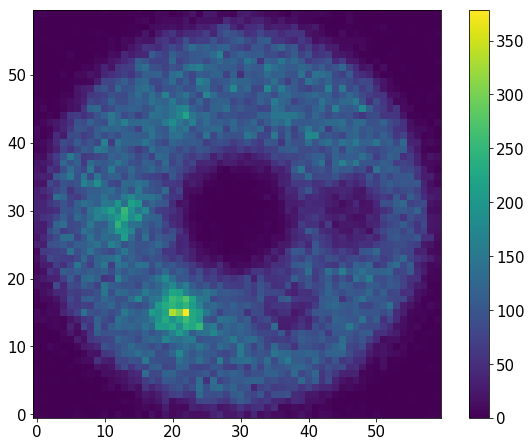

In [39]:
n_iter = 7
slice_min = 25
slice_max = 35
plt.imshow(np.sum(the_imgs[n_iter][:,:,slice_min:slice_max], axis=2).transpose(),origin='lower')
plt.colorbar();

### Plot contrast recovery coefficient (CRC) as a function of the iteration

In [26]:
crcs_hot_0, crcs_hot_1, crcs_hot_2, crcs_hot_3 = [], [], [], []
crcs_cold_0, crcs_cold_1 = [], []

err_crcs_hot_0, err_crcs_hot_1, err_crcs_hot_2, err_crcs_hot_3 = [], [], [], []
err_crcs_cold_0, err_crcs_cold_1 = [], []

for i in range(len(the_imgs)):
    crc_hot0, err_hot0 = fomf.crc_hot3d(the_imgs[i], sig_intensity, bckg_intensity, hot_radii[0], radial_pos,\
                                        hot_angles[0], bckg_radius, phi0, phi_step, n_phi, x_size, y_size, z_size,\
                                        x_bins, y_bins, z_bins)
    crc_hot1, err_hot1 = fomf.crc_hot3d(the_imgs[i], sig_intensity, bckg_intensity, hot_radii[1], radial_pos,\
                                        hot_angles[1], bckg_radius, phi0, phi_step, n_phi, x_size, y_size, z_size,\
                                        x_bins, y_bins, z_bins)
    crc_hot2, err_hot2 = fomf.crc_hot3d(the_imgs[i], sig_intensity, bckg_intensity, hot_radii[2], radial_pos,\
                                        hot_angles[2], bckg_radius, phi0, phi_step, n_phi, x_size, y_size, z_size,\
                                        x_bins, y_bins, z_bins)
    crc_hot3, err_hot3 = fomf.crc_hot3d(the_imgs[i], sig_intensity, bckg_intensity, hot_radii[3], radial_pos,\
                                        hot_angles[3], bckg_radius, phi0, phi_step, n_phi, x_size, y_size, z_size,\
                                        x_bins, y_bins, z_bins)
    crcs_hot_0.append(crc_hot0*100)
    crcs_hot_1.append(crc_hot1*100)
    crcs_hot_2.append(crc_hot2*100)
    crcs_hot_3.append(crc_hot3*100)
    
    err_crcs_hot_0.append(err_hot0*100)
    err_crcs_hot_1.append(err_hot1*100)
    err_crcs_hot_2.append(err_hot2*100)
    err_crcs_hot_3.append(err_hot3*100)
    
    crc_cold0, err_cold0 = fomf.crc_cold3d(the_imgs[i], cold_radii[0], radial_pos, cold_angles[0], bckg_radius, phi0,\
                                           phi_step, n_phi, x_size, y_size, z_size, x_bins, y_bins, z_bins)
    crc_cold1, err_cold1 = fomf.crc_cold3d(the_imgs[i], cold_radii[1], radial_pos, cold_angles[1], bckg_radius, phi0,\
                                           phi_step, n_phi, x_size, y_size, z_size, x_bins, y_bins, z_bins)
    crcs_cold_0.append(crc_cold0*100)
    crcs_cold_1.append(crc_cold1*100)
    
    err_crcs_cold_0.append(err_cold0*100)
    err_crcs_cold_1.append(err_cold1*100)

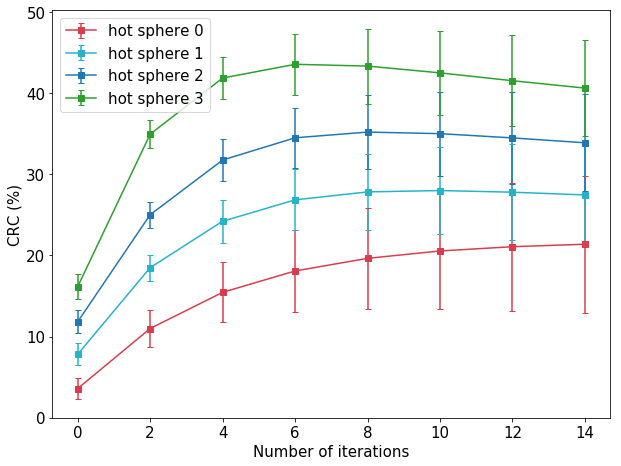

In [29]:
plt.errorbar(list(range(0, n_iterations, save_every)), crcs_hot_0, yerr=err_crcs_hot_0, xerr=None,\
             color=light_red, marker='s', capsize=3, label='hot sphere 0')
plt.errorbar(list(range(0, n_iterations, save_every)), crcs_hot_1, yerr=err_crcs_hot_1, xerr=None,\
             color=light_blue, marker='s', capsize=3, label='hot sphere 1')
plt.errorbar(list(range(0, n_iterations, save_every)), crcs_hot_2, yerr=err_crcs_hot_2, xerr=None,\
             color=blue, marker='s', capsize=3, label='hot sphere 2')
plt.errorbar(list(range(0, n_iterations, save_every)), crcs_hot_3, yerr=err_crcs_hot_3, xerr=None,\
             color=green, marker='s', capsize=3, label='hot sphere 3')
plt.xticks(list(range(0, n_iterations, save_every)))
plt.xlabel('Number of iterations')
plt.ylabel('CRC (%)')
plt.legend(loc=2);



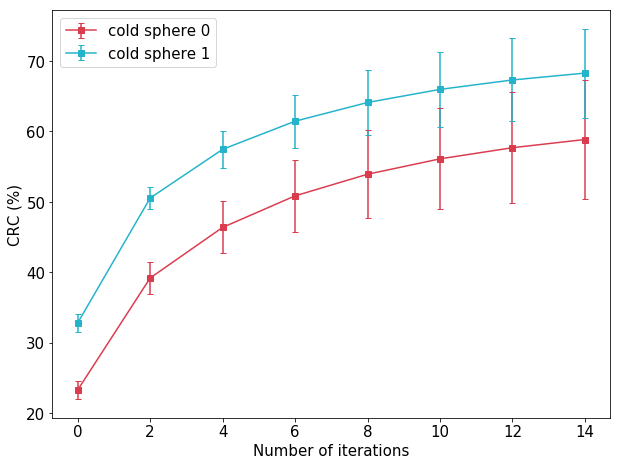

In [32]:
plt.errorbar(list(range(0, n_iterations, save_every)), crcs_cold_0, yerr=err_crcs_hot_0, xerr=None,\
             color=light_red, marker='s', capsize=3, label='cold sphere 0')
plt.errorbar(list(range(0, n_iterations, save_every)), crcs_cold_1, yerr=err_crcs_hot_1, xerr=None,\
             color=light_blue, marker='s', capsize=3, label='cold sphere 1')
plt.xticks(list(range(0, n_iterations, save_every)))
plt.xlabel('Number of iterations')
plt.ylabel('CRC (%)')
plt.legend(loc=2);

### Plot contrast recovery coefficient (CRC) as a function of the activity

Several reconstructions are performed, each one with a different number of coincidences

In [21]:
coincidence_list = list(range(100000, 400000, 100000)) # to make reconstructions with 1e5, 2e5, ... coincidences.
### The numbers of coincidences in this example are very low, so the error bars in the plot are very high.
### A higher number of coincidences needs to be used for a proper analysis.

reconstructions = []

for n in coincidence_list:
    (evt, true_r1, true_phi1, true_z1, true_t1,
     true_r2, true_phi2, true_z2, true_t2,
     r1, phi1, z1, t1,
     r2, phi2, z2, t2) = read_datafile(data_file, n)
    print("Read {} coincidences".format(len(evt)))

    lor_x1 = r1*np.cos(phi1); lor_y1 = r1*np.sin(phi1); lor_z1 = z1; lor_t1 = t1;
    lor_x2 = r2*np.cos(phi2); lor_y2 = r2*np.sin(phi2); lor_z2 = z2; lor_t2 = t2;
    
    rec = myreco.MLEMReconstructor(libpath=path_to_mlem)
    rec.TOF = True
    if not tof:
        rec.TOF = False
    rec.TOF_resolution = tof
    rec.niterations = n_iterations
    rec.save_every = save_every
    rec.prefix = reco_prefix_base + f'_TOF{tof}ps_{n}coincidences'
    rec.reconstruct(lor_x1, lor_y1, lor_z1, lor_t1, lor_x2, lor_y2, lor_z2, lor_t2)
    reconstructions.append(rec)

[100000, 200000, 300000]
Read 100000 coincidences
Sensitivity matrix not specified: assuming a matrix of 1s.
Read 200000 coincidences
Sensitivity matrix not specified: assuming a matrix of 1s.
Read 300000 coincidences
Sensitivity matrix not specified: assuming a matrix of 1s.


Read the images just created

In [22]:
the_imgs = [[] for i in range(0, len(coincidence_list))]

for i in range(0, len(coincidence_list)):
    for j in range(0, n_iterations, save_every):
        img = reconstructions[i].read_image(j)
        the_imgs[i].append(img)

Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes


Calculate the CRC for a given iteration 

In [23]:
it = 6 # number of chosen iteration

crcs_hot_0, crcs_hot_1, crcs_hot_2, crcs_hot_3 = [], [], [], []
crcs_cold_0, crcs_cold_1 = [], []

err_crcs_hot_0, err_crcs_hot_1, err_crcs_hot_2, err_crcs_hot_3 = [], [], [], []
err_crcs_cold_0, err_crcs_cold_1 = [], []

for i in range(len(the_imgs)):
    crc_hot0, err_hot0 = fomf.crc_hot3d(the_imgs[i][it], sig_intensity, bckg_intensity, hot_radii[0], radial_pos,\
                                        hot_angles[0], bckg_radius, phi0, phi_step, n_phi, x_size, y_size, z_size,\
                                        x_bins, y_bins, z_bins)
    crc_hot1, err_hot1 = fomf.crc_hot3d(the_imgs[i][it], sig_intensity, bckg_intensity, hot_radii[1], radial_pos,\
                                        hot_angles[1], bckg_radius, phi0, phi_step, n_phi, x_size, y_size, z_size,\
                                        x_bins, y_bins, z_bins)
    crc_hot2, err_hot2 = fomf.crc_hot3d(the_imgs[i][it], sig_intensity, bckg_intensity, hot_radii[2], radial_pos,\
                                        hot_angles[2], bckg_radius, phi0, phi_step, n_phi, x_size, y_size, z_size,\
                                        x_bins, y_bins, z_bins)
    crc_hot3, err_hot3 = fomf.crc_hot3d(the_imgs[i][it], sig_intensity, bckg_intensity, hot_radii[3], radial_pos,\
                                        hot_angles[3], bckg_radius, phi0, phi_step, n_phi, x_size, y_size, z_size,\
                                        x_bins, y_bins, z_bins)
    crcs_hot_0.append(crc_hot0*100)
    crcs_hot_1.append(crc_hot1*100)
    crcs_hot_2.append(crc_hot2*100)
    crcs_hot_3.append(crc_hot3*100)
    
    err_crcs_hot_0.append(err_hot0*100)
    err_crcs_hot_1.append(err_hot1*100)
    err_crcs_hot_2.append(err_hot2*100)
    err_crcs_hot_3.append(err_hot3*100)
    
    crc_cold0, err_cold0 = fomf.crc_cold3d(the_imgs[i][it], cold_radii[0], radial_pos, cold_angles[0], bckg_radius, phi0,\
                                           phi_step, n_phi, x_size, y_size, z_size, x_bins, y_bins, z_bins)
    crc_cold1, err_cold1 = fomf.crc_cold3d(the_imgs[i][it], cold_radii[1], radial_pos, cold_angles[1], bckg_radius, phi0,\
                                           phi_step, n_phi, x_size, y_size, z_size, x_bins, y_bins, z_bins)
    crcs_cold_0.append(crc_cold0*100)
    crcs_cold_1.append(crc_cold1*100)
    
    err_crcs_cold_0.append(err_cold0*100)
    err_crcs_cold_1.append(err_cold1*100)

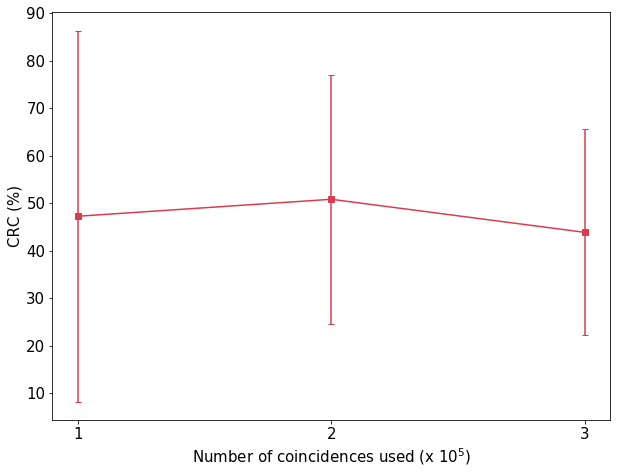

In [27]:
plt.errorbar(list(range(1, len(coincidence_list)+1)), crcs_hot_0, yerr=err_crcs_hot_0, xerr=None, color=light_red,\
             marker='s', capsize=3)
plt.xticks(list(range(1, len(coincidence_list)+1)))
plt.xlabel(f'Number of coincidences used (x $10^5$)')
plt.ylabel('CRC (%)');